# Goals for this model

Given a dataset of movie features, try to predict a movie's IMDB score

# Todo List

- [ ] apply GridSearchCV to each model
- [ ] apply automated feature selection to each model (backward elimination, forward selection)
- [ ] make normalization work for regression models (now that we have models other than linear regression we need it)
- [ ] collect each models' regression statistics into a dataframe for comparing models
- [ ] make many predictions and store results in a dataframe for comparing results (e.g. optimal runtime for horror movies is x )
- [ ] roll in the preprocessing steps to 
  - [ ] handle missing values
  - [ ] cleanse data (e.g. parse country and release date, append release year to name)
  - [ ] split data into new columns (release date to release year, month, day, etc.)

# About the Data

### Movie Industry | Four decades of movies

[via Daniel Grijalva on Kaggle](https://www.kaggle.com/danielgrijalvas/movies)

#### Context

Is the movie industry dying? is Netflix the new entertainment king? Those were the first questions that lead me to create a dataset
focused on movie revenue and analyze it over the last decades. But, why stop there? There are more factors that intervene in this
kind of thing, like actors, genres, user ratings and more. And now, anyone with experience (you) can ask specific questions about the
movie industry, and get answers.

#### Content

There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

- budget: the budget of a movie. Some movies don't have this, so it appears as 0
- company: the production company
- country: country of origin
- director: the director
- genre: main genre of the movie.
- gross: revenue of the movie
- name: name of the movie
- rating: rating of the movie (R, PG, etc.)
- released: release date (YYYY-MM-DD)
- runtime: duration of the movie
- score: IMDb user rating
- votes: number of user votes
- star: main actor/actress
- writer: writer of the movie
- year: year of release

### Acknowledgements

This data was scraped from IMDb.

# Imports

In [622]:
from pathlib import Path

import pandas as pd
import numpy as np
from patsy import dmatrices # https://pypi.org/project/patsy/

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor #Multi-layer Perceptron (not very powerful)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Collection of utility functions used in the book
# Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python (First Edition)
# Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel (c) 2019 John Wiley & Sons, Inc.
#
# Published under MIT License
# https://pypi.org/project/dmba/
# https://www.dataminingbook.com/book/python-edition.
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import backward_elimination, forward_selection, stepwise_selection, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score


# Base Inputs

In [623]:
# input definitions
fPath = '../../_data/_processed/'
fName = 'processed_for_viz.csv' # preprocessing already done
file = ('../../_data/_processed/' + 'processed_for_viz.csv') # preprocessing already done
continuous = True
outcome_var_name = 'score'


# Read Data

In [624]:
# get data
df = pd.read_csv(fPath + fName)

# Basic Data Exploration

In [625]:
print('First few rows')
df.head(10)

First few rows


,name,rating,genre,score,votes,director,writer,star,country,budget,...,release day,release year,release month num,release date,release quarter,release day of week,title,gross profit,profit margin,profit multiple
0,The Shining,R,Drama,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,...,13,1980,6,1980-06-13,2,Friday,The Shining (1980),27998772.0,1.473620,2.473620
1,The Blue Lagoon,R,Adventure,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,...,2,1980,7,1980-07-02,3,Wednesday,The Blue Lagoon (1980),54353106.0,12.078468,13.078468
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,...,20,1980,6,1980-06-20,2,Friday,Star Wars: Episode V - The Empire Strikes Back...,520375067.0,28.909726,29.909726
3,Airplane!,PG,Comedy,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,...,2,1980,7,1980-07-02,3,Wednesday,Airplane! (1980),79953539.0,22.843868,23.843868
4,Caddyshack,R,Comedy,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,...,25,1980,7,1980-07-25,3,Friday,Caddyshack (1980),33846344.0,5.641057,6.641057
5,Friday the 13th,R,Horror,6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,...,9,1980,5,1980-05-09,2,Friday,Friday the 13th (1980),39204601.0,71.281093,72.281093
6,The Blues Brothers,R,Action,7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,27000000.0,...,20,1980,6,1980-06-20,2,Friday,The Blues Brothers (1980),88229890.0,3.267774,4.267774
7,Raging Bull,R,Biography,8.2,330000.0,Martin Scorsese,Jake LaMotta,Robert De Niro,United States,18000000.0,...,19,1980,12,1980-12-19,4,Friday,Raging Bull (1980),5402427.0,0.300135,1.300135
8,Superman II,PG,Action,6.8,101000.0,Richard Lester,Jerry Siegel,Gene Hackman,United States,54000000.0,...,19,1981,6,1981-06-19,2,Friday,Superman II (1981),54185706.0,1.003439,2.003439
9,The Long Riders,R,Biography,7.0,10000.0,Walter Hill,Bill Bryden,David Carradine,United States,10000000.0,...,16,1980,5,1980-05-16,2,Friday,The Long Riders (1980),5795189.0,0.579519,1.579519


In [626]:
df.columns

Index(['name', 'rating', 'genre', 'score', 'votes', 'director', 'writer',
       'star', 'country', 'budget', 'gross revenue', 'company', 'runtime',
       'release month', 'release day', 'release year', 'release month num',
       'release date', 'release quarter', 'release day of week', 'title',
       'gross profit', 'profit margin', 'profit multiple'],
      dtype='object')

## Column Preprocessing

In [627]:
def remove_column_name_special_chars(df):
    print('Replace special characters (spaces, etc) from column names')
    import re
    df.columns = [re.sub('[ |^&+\-%*/=!>]', '_', c) for c in df.columns ]
    return df

df = remove_column_name_special_chars(df)
df.columns

Replace special characters (spaces, etc) from column names


Index(['name', 'rating', 'genre', 'score', 'votes', 'director', 'writer',
       'star', 'country', 'budget', 'gross_revenue', 'company', 'runtime',
       'release_month', 'release_day', 'release_year', 'release_month_num',
       'release_date', 'release_quarter', 'release_day_of_week', 'title',
       'gross_profit', 'profit_margin', 'profit_multiple'],
      dtype='object')

In [628]:
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson
country,United Kingdom
budget,19000000.0


In [629]:
print('Basic Descriptive Statistics')
df.describe()

Basic Descriptive Statistics


,score,votes,budget,gross_revenue,runtime,release_day,release_year,release_month_num,release_quarter,gross_profit,profit_margin,profit_multiple
count,7169.000000,7.169000e+03,7.169000e+03,7.169000e+03,7169.000000,7169.000000,7169.000000,7169.000000,7169.00000,7.169000e+03,7169.000000,7169.000000
mean,6.376510,9.289715e+04,3.180830e+07,8.151105e+07,107.783233,16.067094,2000.886037,6.587251,2.53271,4.970275e+07,4.317142,5.317142
std,0.962503,1.674199e+05,3.751776e+07,1.683817e+08,18.621221,8.543324,11.050197,3.440617,1.12516,1.426387e+08,160.109145,160.109145
min,1.900000,1.050000e+02,6.000000e+03,3.090000e+02,63.000000,1.000000,1980.000000,1.000000,1.00000,-1.580311e+08,-0.999979,0.000021
25%,5.800000,1.100000e+04,1.000000e+07,5.410972e+06,95.000000,9.000000,1992.000000,4.000000,2.00000,-7.634502e+06,-0.570101,0.429899
50%,6.400000,3.600000e+04,2.000000e+07,2.209985e+07,104.000000,16.000000,2001.000000,7.000000,3.00000,4.095658e+06,0.338705,1.338705
75%,7.000000,9.900000e+04,3.700000e+07,7.981794e+07,117.000000,23.000000,2010.000000,10.000000,4.00000,4.651850e+07,2.077351,3.077351
max,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000,31.000000,2020.000000,12.000000,4.00000,2.610246e+09,12889.386667,12890.386667


In [630]:
numeric_features = df.select_dtypes(['number']).columns
non_numeric_features = df.drop(columns=numeric_features).columns
print(numeric_features)
print(non_numeric_features)

Index(['score', 'votes', 'budget', 'gross_revenue', 'runtime', 'release_day',
       'release_year', 'release_month_num', 'release_quarter', 'gross_profit',
       'profit_margin', 'profit_multiple'],
      dtype='object')
Index(['name', 'rating', 'genre', 'director', 'writer', 'star', 'country',
       'company', 'release_month', 'release_date', 'release_day_of_week',
       'title'],
      dtype='object')


Missing values


<AxesSubplot:>

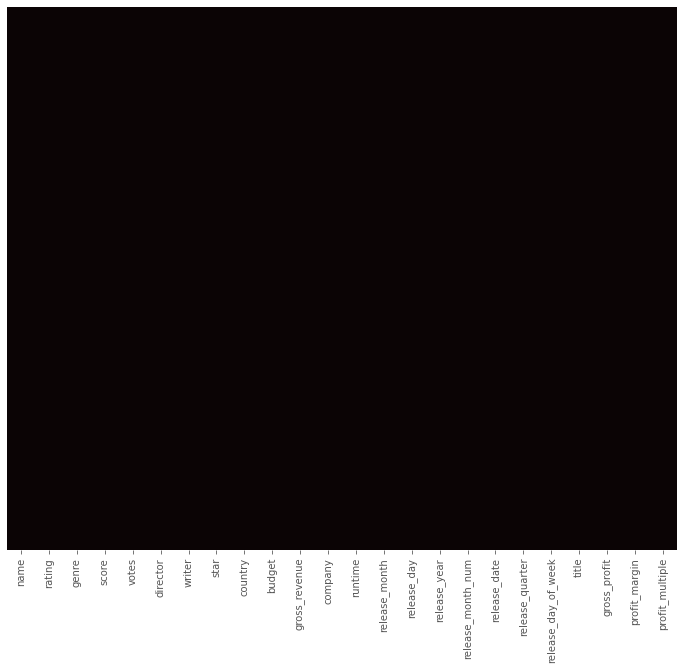

In [631]:
print('Missing values')
plt.figure(figsize=(12,10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='mako')

# Distinct Value Counts


In [632]:
print('Unique Counts')
unique_counts = df.drop(columns=numeric_features).nunique(axis=0).sort_values()
very_unique_cols = unique_counts[unique_counts > 60].index

print(unique_counts)

Unique Counts
release_day_of_week       7
rating                    9
release_month            12
genre                    15
country                  54
company                2126
star                   2506
director               2738
release_date           2766
writer                 4219
name                   7032
title                  7168
dtype: int64


Non numeric features with high distinct value counts can be troublesome with converted to dummy variables

# Preprocessing

In [633]:
df_no_preprocessing = df.copy() # save off a copy of the data prior to preprocessing

### Drop very unique non-numeric columns

In [634]:
df.drop(columns=very_unique_cols, inplace=True)
df

,rating,genre,score,votes,country,budget,gross_revenue,runtime,release_month,release_day,release_year,release_month_num,release_quarter,release_day_of_week,gross_profit,profit_margin,profit_multiple
0,R,Drama,8.4,927000.0,United Kingdom,1.900000e+07,46998772.0,146.0,June,13,1980,6,2,Friday,2.799877e+07,1.473620,2.473620
1,R,Adventure,5.8,65000.0,United States,4.500000e+06,58853106.0,104.0,July,2,1980,7,3,Wednesday,5.435311e+07,12.078468,13.078468
2,PG,Action,8.7,1200000.0,United States,1.800000e+07,538375067.0,124.0,June,20,1980,6,2,Friday,5.203751e+08,28.909726,29.909726
3,PG,Comedy,7.7,221000.0,United States,3.500000e+06,83453539.0,88.0,July,2,1980,7,3,Wednesday,7.995354e+07,22.843868,23.843868
4,R,Comedy,7.3,108000.0,United States,6.000000e+06,39846344.0,98.0,July,25,1980,7,3,Friday,3.384634e+07,5.641057,6.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7164,PG-13,Action,5.4,217000.0,United States,9.129737e+07,166534027.0,151.0,December,25,2020,12,4,Friday,7.523666e+07,0.824084,1.824084
7165,PG,Animation,7.4,120000.0,United States,5.895435e+07,141950608.0,102.0,March,6,2020,3,1,Friday,8.299626e+07,1.407805,2.407805
7166,R,Crime,5.4,2400.0,United States,1.502372e+07,3661.0,98.0,April,17,2020,4,2,Friday,-1.502006e+07,-0.999756,0.000244
7167,PG-13,Comedy,5.0,294.0,United States,3.800552e+07,413378.0,120.0,June,3,2020,6,2,Wednesday,-3.759214e+07,-0.989123,0.010877


# Analyze the Data

### Correlation

Rule of thumb for strength of correlation [via statology](https://www.statology.org/what-is-a-strong-correlation/)

|Absolute value of r | Strength of relationship|
|----|----|
|r < 0.25 | No relationship|
|0.25 < r < 0.5 | Weak relationship|
|0.5 < r < 0.75 | Moderate relationship|
|r > 0.75 | Strong relationship|

In [635]:
def correlation_analysis(df, method='pearson'):
    correlations = df.corr(method=method)
    
    # clustermap
    plt.figure(figsize=(14,12))
    sns.clustermap(correlations, cmap='mako_r', annot=True, vmin=0.25)
    plt.show()
    
    #pairplot
    #sns.pairplot(df, kind="reg", hue= outcome_var)

    # classify the correlations by rule of thumb
    corr_unpiv = correlations.melt(
        ignore_index=False, 
        var_name='var_2', 
        value_name='correlation').reset_index().rename(columns = {'index':'var_1'}).sort_values(by='correlation', ascending=False)
    corr_unpiv['correlation'] = abs(corr_unpiv['correlation'])
    corr_unpiv = corr_unpiv[corr_unpiv.var_1 != corr_unpiv.var_2] # don't want to show relationships with self
    corr_unpiv.drop_duplicates(subset='correlation', inplace=True) # drop rows the report the inverse duplicates <- not an optimal method

    strong = .75
    moderate = .50
    weak = .25
    corr_unpiv['relationship'] = 'Strong'
    corr_unpiv.loc[corr_unpiv['correlation'] < strong, 'relationship'] = 'Moderate'
    corr_unpiv.loc[corr_unpiv['correlation'] < moderate, 'relationship'] = 'Weak'
    corr_unpiv.loc[corr_unpiv['correlation'] < weak, 'relationship'] = 'None'

    strong = corr_unpiv[corr_unpiv['relationship'] == 'Strong']
    moderate = corr_unpiv[corr_unpiv['relationship'] == 'Moderate']
    weak = corr_unpiv[corr_unpiv['relationship'] == 'Weak']
    no_rel = corr_unpiv[corr_unpiv['relationship'] == 'None']
    print(strong)
    print('-'*75)
    print(moderate)
    print('-'*75)
    print(weak)
    print('-'*75)


<Figure size 1008x864 with 0 Axes>

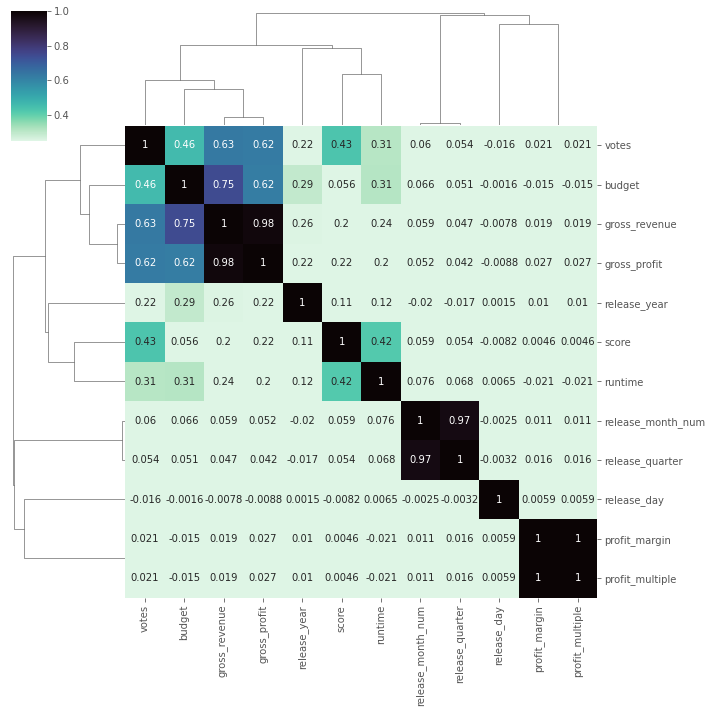

                 var_1            var_2  correlation relationship
142      profit_margin  profit_multiple     1.000000       Strong
45        gross_profit    gross_revenue     0.984493       Strong
103  release_month_num  release_quarter     0.971574       Strong
---------------------------------------------------------------------------
            var_1   var_2  correlation relationship
27  gross_revenue  budget     0.745110     Moderate
15  gross_revenue   votes     0.629913     Moderate
21   gross_profit   votes     0.623497     Moderate
33   gross_profit  budget     0.616558     Moderate
---------------------------------------------------------------------------
           var_1          var_2  correlation relationship
14        budget          votes     0.456610         Weak
12         score          votes     0.429991         Weak
48         score        runtime     0.418002         Weak
28       runtime         budget     0.310798         Weak
16       runtime          votes   

In [636]:
correlation_analysis(df)

<Figure size 1008x864 with 0 Axes>

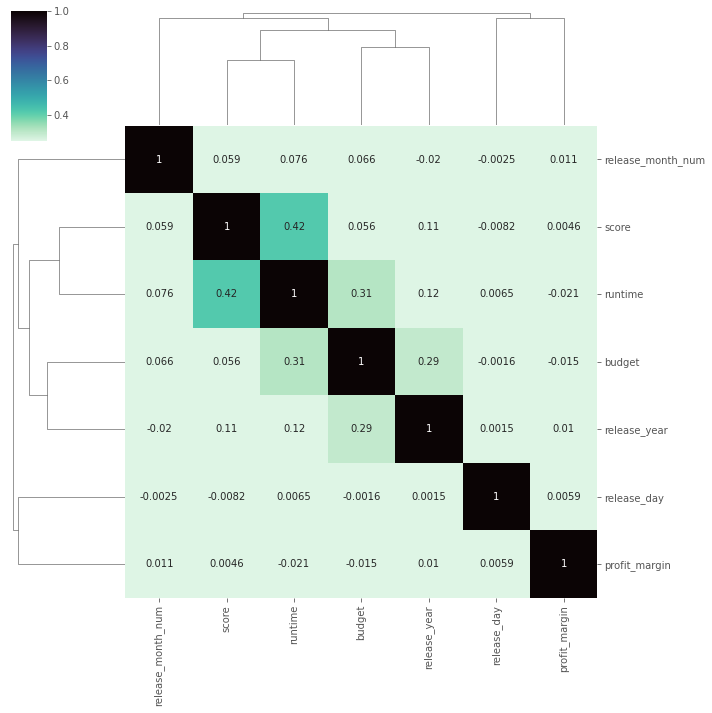

Empty DataFrame
Columns: [var_1, var_2, correlation, relationship]
Index: []
---------------------------------------------------------------------------
Empty DataFrame
Columns: [var_1, var_2, correlation, relationship]
Index: []
---------------------------------------------------------------------------
      var_1         var_2  correlation relationship
14    score       runtime     0.418002         Weak
9   runtime        budget     0.310798         Weak
29   budget  release_year     0.291328         Weak
---------------------------------------------------------------------------


In [637]:
dropped_for_correlation = ['profit_multiple', 'gross_profit', 'release_month', 'release_quarter', 'gross_revenue', 'votes']

correlation_analysis(df.drop(columns=dropped_for_correlation))

In [638]:
df.drop(columns=dropped_for_correlation, inplace=True) # commit to the drop
df

,rating,genre,score,country,budget,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,R,Drama,8.4,United Kingdom,1.900000e+07,146.0,13,1980,6,Friday,1.473620
1,R,Adventure,5.8,United States,4.500000e+06,104.0,2,1980,7,Wednesday,12.078468
2,PG,Action,8.7,United States,1.800000e+07,124.0,20,1980,6,Friday,28.909726
3,PG,Comedy,7.7,United States,3.500000e+06,88.0,2,1980,7,Wednesday,22.843868
4,R,Comedy,7.3,United States,6.000000e+06,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...,...,...
7164,PG-13,Action,5.4,United States,9.129737e+07,151.0,25,2020,12,Friday,0.824084
7165,PG,Animation,7.4,United States,5.895435e+07,102.0,6,2020,3,Friday,1.407805
7166,R,Crime,5.4,United States,1.502372e+07,98.0,17,2020,4,Friday,-0.999756
7167,PG-13,Comedy,5.0,United States,3.800552e+07,120.0,3,2020,6,Wednesday,-0.989123


We now have eliminated highly and moderately correlated features from our data.

### Multicollinearity

Calculate variance inflation factor (VIF)

[ref: statology](https://www.statology.org/how-to-calculate-vif-in-python/)

[ref: medium](https://medium.com/@analyttica/what-is-the-variance-inflation-factor-vif-d1dc12bb9cf5)

In [639]:
def multicollinearity_analysis(df):
    # find design matrix
    tested_features = df.drop(columns=outcome_var_name).columns
    tested_features = '+'.join(tested_features)

    df_sample = df.sample(frac=1, replace=True, random_state=1) # this allows us to runs VIF on just a sample if the dataset and/or tested features list is large

    y, X = dmatrices(f'{outcome_var_name} ~ {tested_features}', data=df_sample, return_type='dataframe')

    # calculate VIF for each explanatory variable (LONG PROCESS)
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable'] = X.columns

    # view VIF for each explanatory variable 
    moderate_thresh = 1.5 # sometimes 2
    high_thresh = 5

    vif['degree'] = 'High'
    vif.loc[vif['VIF'] < high_thresh, 'degree'] = 'Moderate'
    vif.loc[vif['VIF'] < moderate_thresh, 'degree'] = 'Low'

    high_vif = vif[vif['degree'] == 'High']
    moderate_vif = vif[vif['degree'] == 'Moderate']
    low_vif = vif[vif['degree'] == 'Low']


    print(high_vif)
    print(moderate_vif)


In [640]:
multicollinearity_analysis(df)

             VIF                   variable degree
0   43063.974065                  Intercept   High
3       8.448452               rating[T.PG]   High
4      13.519345            rating[T.PG-13]   High
5      15.942273                rating[T.R]   High
24     14.425439       country[T.Australia]   High
28     26.982203          country[T.Canada]   High
30      6.235355           country[T.China]   High
36     34.860205          country[T.France]   High
37     18.553825         country[T.Germany]   High
38      8.368929       country[T.Hong Kong]   High
41      9.322961           country[T.India]   High
44      7.705334         country[T.Ireland]   High
46      8.907815           country[T.Italy]   High
48     11.301650           country[T.Japan]   High
60      6.580919     country[T.South Korea]   High
61      8.547354           country[T.Spain]   High
68    113.108576  country[T.United Kingdom]   High
69    230.517943   country[T.United States]   High
         VIF                   

In [641]:
dropped_for_multicollinearity = ['country', 'rating']

multicollinearity_analysis(df.drop(columns=dropped_for_multicollinearity))


            VIF   variable degree
0  37129.810525  Intercept   High
         VIF         variable    degree
4   1.874391  genre[T.Comedy]  Moderate
6   1.733961   genre[T.Drama]  Moderate
21  1.592989           budget  Moderate


In [642]:
df.drop(columns=dropped_for_multicollinearity, inplace=True) # commit to the drop

In [643]:
print(df.columns)
df

Index(['genre', 'score', 'budget', 'runtime', 'release_day', 'release_year',
       'release_month_num', 'release_day_of_week', 'profit_margin'],
      dtype='object')


,genre,score,budget,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,Drama,8.4,1.900000e+07,146.0,13,1980,6,Friday,1.473620
1,Adventure,5.8,4.500000e+06,104.0,2,1980,7,Wednesday,12.078468
2,Action,8.7,1.800000e+07,124.0,20,1980,6,Friday,28.909726
3,Comedy,7.7,3.500000e+06,88.0,2,1980,7,Wednesday,22.843868
4,Comedy,7.3,6.000000e+06,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...
7164,Action,5.4,9.129737e+07,151.0,25,2020,12,Friday,0.824084
7165,Animation,7.4,5.895435e+07,102.0,6,2020,3,Friday,1.407805
7166,Crime,5.4,1.502372e+07,98.0,17,2020,4,Friday,-0.999756
7167,Comedy,5.0,3.800552e+07,120.0,3,2020,6,Wednesday,-0.989123


We have now dropped highly multicollinear fields from our data

### Drop fields that can't be known at time of prediction

If the model is being used for the purpose of imputing missing data then skip this step.
But if it's truly intended to be used for predictions, we can't provide data that doesn't exist yet.

In [644]:
dropped_for_unknown_at_prediction = ['profit_margin']
df.drop(columns=dropped_for_unknown_at_prediction, inplace=True)

In [645]:
df

,genre,score,budget,runtime,release_day,release_year,release_month_num,release_day_of_week
0,Drama,8.4,1.900000e+07,146.0,13,1980,6,Friday
1,Adventure,5.8,4.500000e+06,104.0,2,1980,7,Wednesday
2,Action,8.7,1.800000e+07,124.0,20,1980,6,Friday
3,Comedy,7.7,3.500000e+06,88.0,2,1980,7,Wednesday
4,Comedy,7.3,6.000000e+06,98.0,25,1980,7,Friday
...,...,...,...,...,...,...,...,...
7164,Action,5.4,9.129737e+07,151.0,25,2020,12,Friday
7165,Animation,7.4,5.895435e+07,102.0,6,2020,3,Friday
7166,Crime,5.4,1.502372e+07,98.0,17,2020,4,Friday
7167,Comedy,5.0,3.800552e+07,120.0,3,2020,6,Wednesday


# Train Models

### Generate dummies

In [646]:
X = pd.get_dummies(df.drop(columns=outcome_var_name), drop_first=True)
y = df[outcome_var_name]

### Noramalization

In [647]:
# TODO: Broken

normalize = False # if classification(discrete variable) problem normalize=True, generally if regression(continuous variable) normalize=False

if normalize:
    X_df = df.drop(columns=[outcome_var_name])
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit(X_df)
    X = pd.DataFrame(scaler.transform(X_df), columns=df.drop(columns=[outcome_var_name]).columns)

### Split Data

In [648]:
# partition data
test_size = 0.3
print(f'test size: {test_size}')
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=test_size, random_state=1)

test size: 0.3


### Linear Regression

In [649]:
if continuous:
    # fitting a regression model
    lm = LinearRegression(normalize=normalize) 
    lm.fit(train_X, train_y)

    # print coefficients
    print('Table 6.3')
    print('intercept ', lm.intercept_)
    print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

    # print performance measures (training data)
    regressionSummary(train_y, lm.predict(train_X))

Table 6.3
intercept  -7.651059153658572
                        Predictor   coefficient
0                          budget -3.124026e-09
1                         runtime  2.209175e-02
2                     release_day -1.438147e-03
3                    release_year  5.767195e-03
4               release_month_num  6.236256e-03
5                 genre_Adventure  1.304396e-01
6                 genre_Animation  1.068185e+00
7                 genre_Biography  5.179397e-01
8                    genre_Comedy  9.267362e-02
9                     genre_Crime  3.465276e-01
10                    genre_Drama  2.639000e-01
11                   genre_Family  3.872626e-01
12                  genre_Fantasy  8.525886e-02
13                   genre_Horror -2.172377e-01
14                  genre_Mystery  4.157664e-01
15                  genre_Romance  2.313683e-01
16                   genre_Sci-Fi  6.619766e-01
17                 genre_Thriller  9.488058e-02
18                  genre_Western -2.528640e-01


### Decision Tree


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.8396
            Mean Absolute Error (MAE) : 0.6430
          Mean Percentage Error (MPE) : -2.2393
Mean Absolute Percentage Error (MAPE) : 11.1541

Regression statistics

                      Mean Error (ME) : -0.0255
       Root Mean Squared Error (RMSE) : 0.8358
            Mean Absolute Error (MAE) : 0.6495
          Mean Percentage Error (MPE) : -2.5338
Mean Absolute Percentage Error (MAPE) : 11.1964


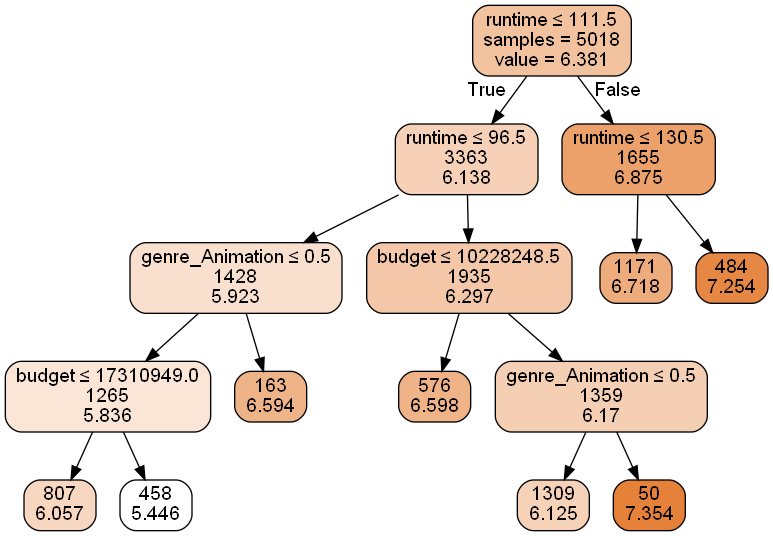

In [650]:
depth = 4
min_split = 20
min_decr = 0.01

if continuous:
    dt = DecisionTreeRegressor(max_depth=depth, min_samples_split=min_split, min_impurity_decrease=min_decr)
    dt.fit(train_X, train_y)
    
    regressionSummary(train_y, dt.predict(train_X))
    regressionSummary(valid_y, dt.predict(valid_X))
else :
    dt = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split, min_impurity_decrease=min_decr)
    dt.fit(train_X, train_y)
    classificationSummary(train_y, dt.predict(train_X))
    classificationSummary(valid_y, dt.predict(valid_X))

plotDecisionTree(dt, feature_names=train_X.columns)

### Random Forest

In [651]:
depth = 7
n = 100

if continuous:
    rf = RandomForestRegressor(n_estimators=n,max_depth=depth)
    rf.fit(train_X, train_y)
    regressionSummary(train_y, rf.predict(train_X))
    regressionSummary(valid_y, rf.predict(valid_X))
else: 
    rf = RandomForestClassifier(n_estimators=n,max_depth=depth)
    rf.fit(train_X, train_y)
    classificationSummary(train_y, rf.predict(train_X))
    classificationSummary(valid_y, rf.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0010
       Root Mean Squared Error (RMSE) : 0.7344
            Mean Absolute Error (MAE) : 0.5560
          Mean Percentage Error (MPE) : -1.8868
Mean Absolute Percentage Error (MAPE) : 9.6705

Regression statistics

                      Mean Error (ME) : -0.0291
       Root Mean Squared Error (RMSE) : 0.7907
            Mean Absolute Error (MAE) : 0.6053
          Mean Percentage Error (MPE) : -2.4164
Mean Absolute Percentage Error (MAPE) : 10.4525


### AdaBoost

In [652]:
depth = 8
n = 100

if continuous:
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=depth), n_estimators=n)
    ada.fit(train_X, train_y)
    regressionSummary(train_y, ada.predict(train_X))
    regressionSummary(valid_y, ada.predict(valid_X))
else:
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=n)
    ada.fit(train_X, train_y)
    classificationSummary(train_y, ada.predict(train_X))
    classificationSummary(valid_y, ada.predict(valid_X))



Regression statistics

                      Mean Error (ME) : 0.0906
       Root Mean Squared Error (RMSE) : 0.6198
            Mean Absolute Error (MAE) : 0.5188
          Mean Percentage Error (MPE) : 0.1169
Mean Absolute Percentage Error (MAPE) : 8.5183

Regression statistics

                      Mean Error (ME) : 0.0642
       Root Mean Squared Error (RMSE) : 0.8147
            Mean Absolute Error (MAE) : 0.6306
          Mean Percentage Error (MPE) : -0.8820
Mean Absolute Percentage Error (MAPE) : 10.6599


### XGBoost

In [653]:
gamma = 0.7
use_label_encoder = False

if continuous:
    xgb = XGBRegressor(gamma=gamma, use_label_encoder=use_label_encoder)
    xgb.fit(train_X, train_y)
    regressionSummary(train_y, xgb.predict(train_X))
    regressionSummary(valid_y, xgb.predict(valid_X))
else:
    xgb = XGBClassifier(use_label_encoder=use_label_encoder)
    xgb.fit(train_X, train_y)
    classificationSummary(train_y, xgb.predict(train_X))
    classificationSummary(valid_y, xgb.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.5769
            Mean Absolute Error (MAE) : 0.4362
          Mean Percentage Error (MPE) : -1.3372
Mean Absolute Percentage Error (MAPE) : 7.4864

Regression statistics

                      Mean Error (ME) : -0.0260
       Root Mean Squared Error (RMSE) : 0.8231
            Mean Absolute Error (MAE) : 0.6310
          Mean Percentage Error (MPE) : -2.2844
Mean Absolute Percentage Error (MAPE) : 10.8095


### Gradient Boost

In [654]:
if continuous:
    gb = GradientBoostingRegressor()
    gb.fit(train_X, train_y)
    regressionSummary(train_y, gb.predict(train_X))
    regressionSummary(valid_y, gb.predict(valid_X))
else:
    gb = GradientBoostingClassifier()
    gb.fit(train_X, train_y)
    classificationSummary(train_y, gb.predict(train_X))
    classificationSummary(valid_y, gb.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.7651
            Mean Absolute Error (MAE) : 0.5764
          Mean Percentage Error (MPE) : -2.0047
Mean Absolute Percentage Error (MAPE) : 10.0414

Regression statistics

                      Mean Error (ME) : -0.0279
       Root Mean Squared Error (RMSE) : 0.7827
            Mean Absolute Error (MAE) : 0.6019
          Mean Percentage Error (MPE) : -2.3858
Mean Absolute Percentage Error (MAPE) : 10.3884


### knn

See [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for details on scoring options.

In [655]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

grid_params ={'n_neighbors':range(15, 30),
              'weights':['uniform','distance']}
cv = 5 # cross-validation splitting strategy 5-fold cross validation is the default
n_jobs = -1 # number of jobs to run in parellel -1 means use all of your processors

if continuous:
    scoring = 'neg_mean_absolute_percentage_error'
    gs = GridSearchCV(KNeighborsRegressor(),grid_params,cv=cv,n_jobs=n_jobs,scoring=scoring)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    knn= gs.best_estimator_

    regressionSummary(train_y, knn.predict(train_X))
    regressionSummary(valid_y, knn.predict(valid_X))
else:
    scoring='accuracy'
    gs = GridSearchCV(KNeighborsClassifier(),grid_params,cv=cv,n_jobs=n_jobs,scoring=scoring)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    knn= gs.best_estimator_

    classificationSummary(train_y, knn.predict(train_X))
    classificationSummary(valid_y, knn.predict(valid_X))

{'n_neighbors': 19, 'weights': 'uniform'}

Regression statistics

                      Mean Error (ME) : 0.0275
       Root Mean Squared Error (RMSE) : 0.8641
            Mean Absolute Error (MAE) : 0.6685
          Mean Percentage Error (MPE) : -1.9649
Mean Absolute Percentage Error (MAPE) : 11.5027

Regression statistics

                      Mean Error (ME) : -0.0099
       Root Mean Squared Error (RMSE) : 0.9020
            Mean Absolute Error (MAE) : 0.6993
          Mean Percentage Error (MPE) : -2.5966
Mean Absolute Percentage Error (MAPE) : 12.0273


### Neural Net

In [656]:
# Neural net
hidden_layers = 2
activation = 'tanh' #logistic' (sigmoid), 'identity', 'tanh', 'relu'
solver = 'adam' # 'lbfgs', 'sgd', 'adam'
random_state = 1 # default=None
max_iter = 1000 # default=200
alpha = 0.0001 # default=0.0001

if continuous:
    nn = MLPRegressor(hidden_layer_sizes=(hidden_layers), activation=activation, solver=solver, random_state=random_state, max_iter=max_iter, alpha=alpha) 
    nn.fit(train_X, train_y)

    regressionSummary(train_y, nn.predict(train_X))
    regressionSummary(valid_y, nn.predict(valid_X))
else:
    nn = MLPClassifier(hidden_layer_sizes=(hidden_layers), activation=activation, solver=solver, random_state=random_state, max_iter=max_iter, alpha=alpha)
    nn.fit(train_X, train_y)

    classificationSummary(train_y, nn.predict(train_X))
    classificationSummary(valid_y, nn.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0136
       Root Mean Squared Error (RMSE) : 0.9670
            Mean Absolute Error (MAE) : 0.7515
          Mean Percentage Error (MPE) : -2.6627
Mean Absolute Percentage Error (MAPE) : 12.9976

Regression statistics

                      Mean Error (ME) : -0.0014
       Root Mean Squared Error (RMSE) : 0.9518
            Mean Absolute Error (MAE) : 0.7451
          Mean Percentage Error (MPE) : -2.7745
Mean Absolute Percentage Error (MAPE) : 12.8305


# Select Model

TODO: need to actually evaluate the Error statistics of the various models currently we just pick one

In [668]:
selected_model = lm # change this to select a different model

# Tune Model

### Make Predictions on Validation Data

In [669]:
# Use predict() to make predictions on a new set
selected_model_pred = selected_model.predict(valid_X)
result = pd.DataFrame({'Predicted': selected_model_pred, 'Actual': valid_y, 'Residual': valid_y - selected_model_pred})

print('First few results')
print(result.head(20))

First few results
      Predicted  Actual  Residual
4332   6.497111     7.0  0.502889
1117   6.198994     6.5  0.301006
4492   6.917585     5.7 -1.217585
7107   6.040430     6.3  0.259570
1475   6.348435     6.3 -0.048435
6908   5.919096     6.7  0.780904
462    5.644576     5.8  0.155424
6392   6.378561     7.1  0.721439
5083   6.352635     5.8 -0.552635
2684   6.557846     6.1 -0.457846
3709   6.238934     7.0  0.761066
1558   6.652487     7.6  0.947513
1651   7.476005     7.5  0.023995
299    5.768988     5.7 -0.068988
447    6.165546     4.7 -1.465546
325    5.753103     6.4  0.646897
4286   6.676983     6.2 -0.476983
6842   6.294097     7.0  0.705903
1877   6.447491     5.8 -0.647491
758    6.052798     5.9 -0.152798


### Analyze the Results

In [670]:
# print performance measures
regressionSummary(valid_y, selected_model_pred)


Regression statistics

                      Mean Error (ME) : -0.0196
       Root Mean Squared Error (RMSE) : 0.8208
            Mean Absolute Error (MAE) : 0.6310
          Mean Percentage Error (MPE) : -2.4503
Mean Absolute Percentage Error (MAPE) : 10.9145


0.8433286843328685


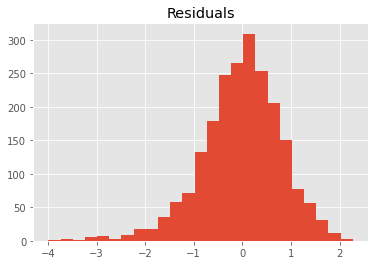

In [671]:
def residual_hist(model, valid_X, valid_y, bins, bounds):
    # plotting histogram of validation errors
    residual_bound = bounds

    predicted = model.predict(valid_X)
    all_residuals = valid_y - predicted

    # Determine the percentage of datapoints with a residual in bounds = approx. 75%
    print(len(all_residuals[(all_residuals > -residual_bound) & (all_residuals < residual_bound)]) / len(all_residuals))

    pd.DataFrame({'Residuals': all_residuals}).hist(bins=bins)
    plt.show()

# plotting histogram of validation errors
residual_hist(selected_model, valid_X, valid_y, 25, 1.1)

### Tune the model

# Make a totally new prediction

In [672]:
# create a movie (in this data a movie can't have more than one rating nor more than one genre)
newMovie = pd.DataFrame([{
    'budget': 1_000_000,
    'runtime': 3*60,
    'release_day': 15,
    'release_year': 2022,
    'release_month_num': 6,
    'genre_Adventure': 0,
    'genre_Animation': 0,
    'genre_Biography': 0,
    'genre_Comedy': 0,
    'genre_Crime': 0,
    'genre_Drama': 0,
    'genre_Family': 0,
    'genre_Fantasy': 0,
    'genre_Horror': 1,
    'genre_Mystery': 0,
    'genre_Romance': 0,
    'genre_Sci-Fi': 0,
    'genre_Thriller': 0,
    'genre_Western': 0,
    'genre_Music': 0,
    'genre_Musical': 0,
    'genre_Sport': 0,
    'release_day_of_week_Monday': 0, 
    'release_day_of_week_Saturday': 0, 
    'release_day_of_week_Sunday': 0, 
    'release_day_of_week_Thursday': 0, 
    'release_day_of_week_Tuesday': 0, 
    'release_day_of_week_Wednesday': 1
}])

newMovie_thin = newMovie.loc[:, ~(newMovie == 0).any()]

# predict it's score
print(f'What score do we expect from a new movie with the following features?\n{newMovie_thin.T}\n')
print(f'{outcome_var_name}: {selected_model.predict(newMovie[X.columns])}')


What score do we expect from a new movie with the following features?
                                     0
budget                         1000000
runtime                            180
release_day                         15
release_year                      2022
release_month_num                    6
genre_Horror                         1
release_day_of_week_Wednesday        1

score: [7.87557517]
